## Analyzing impact of smoke on mortality from respiratory diseases

This notebook explores the relationship between wildfire smoke exposure and respiratory mortality rates in Birmingham, Alabama. The analysis involves:

1. Analyzing respiratory mortality data from the CDC to understand trends and correlations.
2. Building a time-series model to forecast respiratory mortality rates using the Smoke Index as a predictor.
3. Investigating gender-specific impacts of smoke on respiratory mortality.

The findings aim to provide actionable insights for public health planning and policymaking, with a focus on equity and data-driven decision-making.


In [53]:
#Import necessary packages

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from prophet import Prophet

### Data Cleaning and Preparation

We use two datasets from CDC's Wonder database which have Mortality data for 1979-1998 and 1999-2016 respectively. The detailed screenshots of the query used to extract this data can be found in respiratory-diseases/data-request 

[1] Centers for Disease Control and Prevention, National Center for Health Statistics. National Vital Statistics System, Mortality: Compressed Mortality File 1979-1998. CDC WONDER On-line Database, compiled from Compressed Mortality File CMF 1968-1988, Series 20, No. 2A, 2000 and CMF 1989-1998, Series 20, No. 2E, 2003. Accessed at http://wonder.cdc.gov/cmf-icd9.html

[2] Centers for Disease Control and Prevention, National Center for Health Statistics. National Vital Statistics System, Mortality: Compressed Mortality File 1999-2016 on CDC WONDER Online Database, released June 2017. Data are from the Compressed Mortality File 1999-2016 Series 20 No. 2U, 2016, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/cmf-icd10.html

Reading and cleaning first file

In [ ]:
mortality_1 = pd.read_csv('raw-data/Compressed Mortality, 1979-1998.txt', delimiter='\t')
mortality_1

,Notes,Age Group,Age Group Code,Race,Race Code,Gender,Gender Code,Cause of death,Cause of death Code,Year,Year Code,Deaths,Population,Crude Rate,% of Total Deaths
0,NaN,< 1 year,1,Black or African American,2054-5,Female,F,"Other diseases of larynx, not elsewhere classi...",478.7,1986.0,1986.0,1.0,2189.0,45.7 (Unreliable),0.0%
1,NaN,< 1 year,1,Black or African American,2054-5,Female,F,"Pneumonia, organism unspecified",486.0,1983.0,1983.0,1.0,2075.0,48.2 (Unreliable),0.0%
2,NaN,< 1 year,1,Black or African American,2054-5,Female,F,"Pneumonia, organism unspecified",486.0,1987.0,1987.0,1.0,2142.0,46.7 (Unreliable),0.0%
3,NaN,< 1 year,1,Black or African American,2054-5,Female,F,Pulmonary collapse,518.0,1979.0,1979.0,1.0,2274.0,44.0 (Unreliable),0.0%
4,NaN,< 1 year,1,Black or African American,2054-5,Female,F,Other diseases of lung,518.8,1980.0,1980.0,1.0,2318.0,43.1 (Unreliable),0.0%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,The population figures in this table for 1980 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1859,figures for 1991-98 are bridged-race intercens...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860,"4. Deaths of persons with Age ""Not Stated"" are...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1861,"so are not included in age-specific counts, ag...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We notice text rows at the bottom which contain licensing information, so we remove those for our analysis

In [2]:
mortality_1[1826:]

,Notes,Age Group,Age Group Code,Race,Race Code,Gender,Gender Code,Cause of death,Cause of death Code,Year,Year Code,Deaths,Population,Crude Rate,% of Total Deaths
1826,NaN,85+ years,85+,White,2106-3,Male,M,"Other diseases of respiratory system, not else...",519.8,1982.0,1982.0,1.0,1162.0,86.1 (Unreliable),0.0%
1827,---,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1828,"Dataset: Compressed Mortality, 1979-1998",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1829,Query Parameters:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1830,ICD-9 Codes: 460-519 (Diseases of the respirat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1831,"States: Jefferson County, AL (01073)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1832,Group By: Age Group; Race; Gender; Cause of de...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1833,Show Totals: Disabled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1834,Show Zero Values: Disabled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1835,Show Suppressed: True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
mortality_1 = mortality_1[:1827]

We can view the cleaned dataset now

In [4]:
mortality_1.describe

<bound method NDFrame.describe of      Notes  Age Group Age Group Code                       Race Race Code  \
0      NaN   < 1 year              1  Black or African American    2054-5   
1      NaN   < 1 year              1  Black or African American    2054-5   
2      NaN   < 1 year              1  Black or African American    2054-5   
3      NaN   < 1 year              1  Black or African American    2054-5   
4      NaN   < 1 year              1  Black or African American    2054-5   
...    ...        ...            ...                        ...       ...   
1822   NaN  85+ years            85+                      White    2106-3   
1823   NaN  85+ years            85+                      White    2106-3   
1824   NaN  85+ years            85+                      White    2106-3   
1825   NaN  85+ years            85+                      White    2106-3   
1826   NaN  85+ years            85+                      White    2106-3   

      Gender Gender Code                 

Preparing the second file

In [5]:
mortality_2 = pd.read_csv('raw-data/Compressed Mortality, 1999-2016.txt', delimiter='\t')
mortality_2

,Notes,Age Group,Age Group Code,Race,Race Code,Gender,Gender Code,Cause of death,Cause of death Code,Year,Year Code,Deaths,Population,Crude Rate,% of Total Deaths
0,NaN,55-64 years,55-64,White,2106-3,Female,F,"Chronic obstructive pulmonary disease, unspeci...",J44.9,2002.0,2002.0,11.0,21201.0,51.9 (Unreliable),0.1%
1,NaN,55-64 years,55-64,White,2106-3,Female,F,"Chronic obstructive pulmonary disease, unspeci...",J44.9,2009.0,2009.0,11.0,24313.0,45.2 (Unreliable),0.1%
2,NaN,55-64 years,55-64,White,2106-3,Female,F,"Chronic obstructive pulmonary disease, unspeci...",J44.9,2010.0,2010.0,12.0,24796.0,48.4 (Unreliable),0.1%
3,NaN,55-64 years,55-64,White,2106-3,Female,F,"Chronic obstructive pulmonary disease, unspeci...",J44.9,2011.0,2011.0,10.0,25517.0,39.2 (Unreliable),0.1%
4,NaN,55-64 years,55-64,White,2106-3,Female,F,"Chronic obstructive pulmonary disease, unspeci...",J44.9,2013.0,2013.0,10.0,25401.0,39.4 (Unreliable),0.1%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,http://wonder.cdc.gov/wonder/help/cmf.html#Rac...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,6. Changes to cause of death classification af...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,http://wonder.cdc.gov/wonder/help/cmf.html#ICD...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,"7. As of April 3, 2017, the underlying cause o...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Removing the bottom rows from our analysis again

In [6]:
mortality_2[229:]

,Notes,Age Group,Age Group Code,Race,Race Code,Gender,Gender Code,Cause of death,Cause of death Code,Year,Year Code,Deaths,Population,Crude Rate,% of Total Deaths
229,NaN,85+ years,85+,White,2106-3,Male,M,Pneumonitis due to food and vomit,J69.0,2013.0,2013.0,10.0,3095.0,323.1 (Unreliable),0.1%
230,---,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,"Dataset: Compressed Mortality, 1999-2016",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,Query Parameters:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,ICD-10 Codes: J00-J98 (Diseases of the respira...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,"States: Jefferson County, AL (01073)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,Group By: Age Group; Race; Gender; Cause of de...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,Show Totals: Disabled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,Show Zero Values: Disabled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,Show Suppressed: True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
mortality_2 = mortality_2[:230]

We can view the second dataset below

In [8]:
mortality_2.describe

<bound method NDFrame.describe of     Notes    Age Group Age Group Code   Race Race Code  Gender Gender Code  \
0     NaN  55-64 years          55-64  White    2106-3  Female           F   
1     NaN  55-64 years          55-64  White    2106-3  Female           F   
2     NaN  55-64 years          55-64  White    2106-3  Female           F   
3     NaN  55-64 years          55-64  White    2106-3  Female           F   
4     NaN  55-64 years          55-64  White    2106-3  Female           F   
..    ...          ...            ...    ...       ...     ...         ...   
225   NaN    85+ years            85+  White    2106-3    Male           M   
226   NaN    85+ years            85+  White    2106-3    Male           M   
227   NaN    85+ years            85+  White    2106-3    Male           M   
228   NaN    85+ years            85+  White    2106-3    Male           M   
229   NaN    85+ years            85+  White    2106-3    Male           M   

                             

We compare columns on the two datasets before concatenation. Here we find the columns are aligned so can concatenate without issues

In [9]:
print(mortality_1.columns)
print(mortality_2.columns)

Index(['Notes', 'Age Group', 'Age Group Code', 'Race', 'Race Code', 'Gender',
       'Gender Code', 'Cause of death', 'Cause of death Code', 'Year',
       'Year Code', 'Deaths', 'Population', 'Crude Rate', '% of Total Deaths'],
      dtype='object')
Index(['Notes', 'Age Group', 'Age Group Code', 'Race', 'Race Code', 'Gender',
       'Gender Code', 'Cause of death', 'Cause of death Code', 'Year',
       'Year Code', 'Deaths', 'Population', 'Crude Rate', '% of Total Deaths'],
      dtype='object')


In [10]:
mortality = pd.concat([mortality_1, mortality_2], ignore_index=True)

The concatenated dataset looks like below

In [11]:
mortality.describe

<bound method NDFrame.describe of      Notes  Age Group Age Group Code                       Race Race Code  \
0      NaN   < 1 year              1  Black or African American    2054-5   
1      NaN   < 1 year              1  Black or African American    2054-5   
2      NaN   < 1 year              1  Black or African American    2054-5   
3      NaN   < 1 year              1  Black or African American    2054-5   
4      NaN   < 1 year              1  Black or African American    2054-5   
...    ...        ...            ...                        ...       ...   
2052   NaN  85+ years            85+                      White    2106-3   
2053   NaN  85+ years            85+                      White    2106-3   
2054   NaN  85+ years            85+                      White    2106-3   
2055   NaN  85+ years            85+                      White    2106-3   
2056   NaN  85+ years            85+                      White    2106-3   

      Gender Gender Code                 

Next we explore our dataset for what its columns contain - causes of deaths, gender, age, and race information

In [12]:
unique_causes_of_death = mortality['Cause of death'].unique()
print(unique_causes_of_death)

['Other diseases of larynx, not elsewhere classified'
 'Pneumonia, organism unspecified' 'Pulmonary collapse'
 'Other diseases of lung' 'Viral pneumonia, unspecified'
 'Pneumonia due to streptococcus' 'Due to inhalation of food or vomitus'
 'Unspecified site'
 'Pneumococcal pneumonia [streptococcus pneumoniae pneumonia]'
 'Other diseases of trachea and bronchus, not elsewhere classified'
 'Other diseases of respiratory system, not elsewhere classified'
 'Acute epiglottitis'
 'Pulmonary insufficiency following trauma and surgery'
 'Asthma, unspecified' 'Bronchitis, not specified as acute or chronic'
 'Bacterial pneumonia unspecified'
 'Bronchopneumonia, organism unspecified' 'Pneumothorax'
 'Pulmonary congestion and hypostasis' 'With pneumonia'
 'Pneumonia due to other specified bacteria'
 'Other diseases of pharynx, not elsewhere classified' 'Mediastinitis'
 'Unspecified sinusitis (chronic)' 'Without mention of fistula'
 'Abscess of lung' 'Postinflammatory pulmonary fibrosis'
 'Other s

In [13]:
age_groups = mortality['Age Group'].unique()
print(age_groups)

['< 1 year' '1-4 years' '5-9 years' '10-14 years' '15-19 years'
 '20-24 years' '25-34 years' '35-44 years' '45-54 years' '55-64 years'
 '65-74 years' '75-84 years' '85+ years']


In [14]:
races = mortality['Race'].unique()
print(races)

['Black or African American' 'White' 'Other Race']


In [15]:
genders = mortality['Gender'].unique()
print(genders)

['Female' 'Male']


In [19]:
# Group by 'Year' and aggregate the sum of 'Deaths'
mortality_grouped = mortality.groupby('Year').agg({'Deaths': 'sum'}).reset_index()
mortality_grouped.head(5)

,Year,Deaths
0,1979.0,352.0
1,1980.0,386.0
2,1981.0,447.0
3,1982.0,435.0
4,1983.0,441.0


We can explore what Respiratory deaths look like across years below

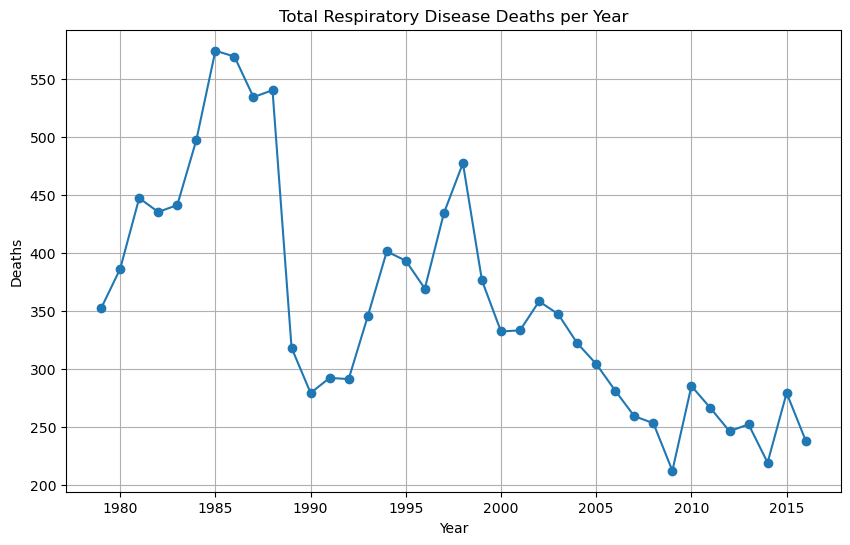

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mortality_grouped['Year'], mortality_grouped['Deaths'], marker='o')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.title('Total Respiratory Disease Deaths per Year')
plt.grid(True)
plt.show()

Now we need to combine our smoke estimate data (from common-analysis) with mortality data

In [23]:
# Get yearly smoke index from common-analysis

yearly_smoke_index = pd.read_csv("../common-analysis/final-data/yearly_smoke_index.csv")
yearly_smoke_index.rename(columns={"Fire_Year": "Year"}, inplace=True)
yearly_smoke_index

,Year,yearly_smoke_index
0,1920,0.000958
1,1921,0.000009
2,1923,0.001438
3,1925,0.039641
4,1926,0.000164
...,...,...
91,2016,1.877045
92,2017,0.978377
93,2018,0.984609
94,2019,1.980190


In [25]:
# Merge the datasets on the year
combined_data = pd.merge(yearly_smoke_index, mortality_grouped, on='Year', how='inner')
combined_data.rename(columns={"yearly_smoke_index":"Smoke_Index"}, inplace=True)
combined_data.head(5)

,Year,Smoke_Index,Deaths
0,1979,0.001309,352.0
1,1980,0.004536,386.0
2,1981,0.002687,447.0
3,1982,0.000443,435.0
4,1983,0.000416,441.0


## Exploratory Data Analysis

We can plot Smoke and Deaths on the same plot (with differnet axes for scale) to identify any time trends. Here we see clear time trends for both variables. Smoke index is increasing over time and Deaths are going down over time. To identify any correlations between these two variables we will need to control for this time trend

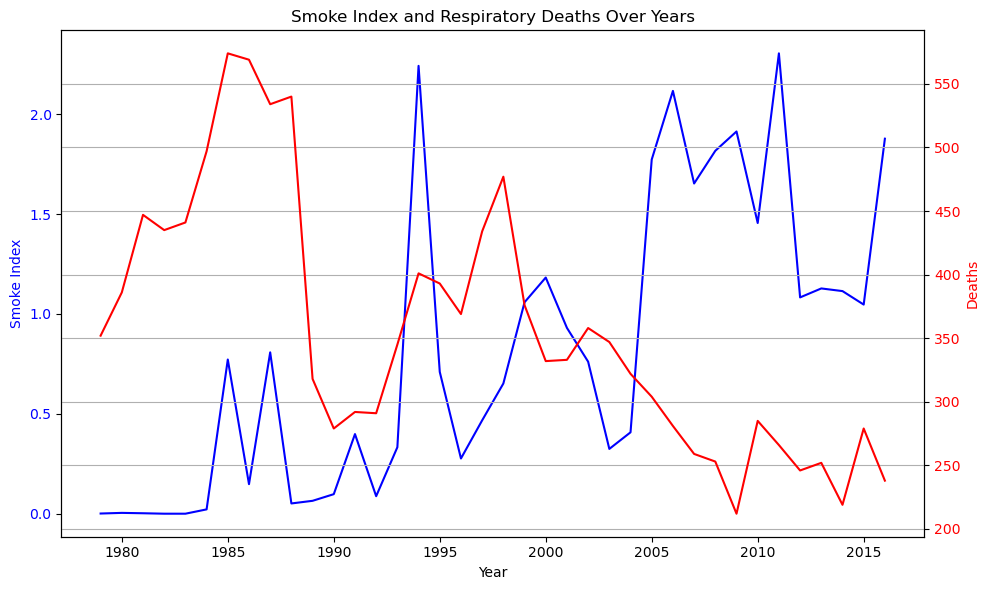

In [66]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(combined_data['Year'], combined_data['Smoke_Index'], label='Smoke Index', color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(combined_data['Year'], combined_data['Deaths'], label='Deaths', color='red')
ax2.set_ylabel('Deaths', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Smoke Index and Respiratory Deaths Over Years')
fig.tight_layout()
plt.grid(True)
plt.show()

A raw calculation of correlation gives a negative correlation as expected due to the time trend obfuscating any potential correlations.

In [28]:
# Check the correlation
correlation = combined_data['Smoke_Index'].corr(combined_data['Deaths'])
print(f"Correlation between smoke estimate and respiratory deaths: {correlation:.2f}")

Correlation between smoke estimate and respiratory deaths: -0.51


We also compare Deaths with lagged smoke indices as Mortality could lag in comparison to a high smoke event. However we still get negative correlations

In [29]:
combined_data_lagged = combined_data

# Create lagged variables for the smoke index
combined_data_lagged['Smoke_Index_t-1'] = combined_data_lagged['Smoke_Index'].shift(1)  # 1-year lag
combined_data_lagged['Smoke_Index_t-2'] = combined_data_lagged['Smoke_Index'].shift(2)  # 2-year lag
# combined_data_lagged.dropna(inplace=True)  # Drop rows with NaN values due to lagging

# Compute correlation for each lag
correlation_t0 = combined_data_lagged['Smoke_Index'].corr(combined_data_lagged['Deaths'])
correlation_t1 = combined_data_lagged['Smoke_Index_t-1'].corr(combined_data_lagged['Deaths'])
correlation_t2 = combined_data_lagged['Smoke_Index_t-2'].corr(combined_data_lagged['Deaths'])

# Print the results
print(f"Correlation with current year's smoke index: {correlation_t0:.2f}")
print(f"Correlation with 1-year lagged smoke index: {correlation_t1:.2f}")
print(f"Correlation with 2-year lagged smoke index: {correlation_t2:.2f}")


Correlation with current year's smoke index: -0.51
Correlation with 1-year lagged smoke index: -0.52
Correlation with 2-year lagged smoke index: -0.59


We add more data from our earlier analysis - Number of fires and Area of Fire to identify any correlations with Deaths

In [32]:
gdf_analysis = gpd.read_file("../common-analysis/intermediate-data/gdf_analysis.geojson")

In [33]:
gdf_analysis.head(5)

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,distance_to_city,geometry
0,2311,2311,Wildfire,1920,1,"1 (7), 3 (7)",498.893971,201.895227,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (14),...,Prescribed fire data in this dataset represent...,None,None,0.052373,NaN,No,22009.648471,2.018952e+06,459119.316947,"POLYGON ((-9303991.850 4230514.092, -9303709.4..."
1,2875,2875,Wildfire,1923,1,"1 (1), 3 (1)",856.766473,346.721090,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),...,Prescribed fire data in this dataset represent...,None,None,0.083069,NaN,No,22902.106835,3.467211e+06,491084.993644,"POLYGON ((-9257807.789 4223584.801, -9257803.9..."
2,3376,3376,Wildfire,1925,1,"1 (8), 3 (8)",5870.435330,2375.680892,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (16),...,Prescribed fire data in this dataset represent...,None,None,0.014773,NaN,No,142156.948009,2.375681e+07,456689.773943,"POLYGON ((-9300656.569 4221339.666, -9300607.3..."
3,3377,3377,Wildfire,1925,1,"1 (6), 3 (6)",8709.390470,3524.565276,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (12),...,Prescribed fire data in this dataset represent...,None,None,0.017926,NaN,No,157186.693274,3.524565e+07,491805.342787,"POLYGON ((-9257545.201 4231419.767, -9257517.0..."
4,3381,3381,Wildfire,1925,1,"1 (1), 3 (1)",2272.104218,919.487955,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),...,Prescribed fire data in this dataset represent...,None,None,0.192033,NaN,No,24529.569086,9.194880e+06,453450.497004,"POLYGON ((-9294315.257 4213530.582, -9294366.2..."


In [34]:
#Group by Fire_Year and aggregate the number of fires and area burnt
fire_data = gdf_analysis.groupby('Fire_Year').agg(
    number_of_fires=('USGS_Assigned_ID', 'count'),  # Count the number of fires
    area_burnt=('GIS_Acres', 'sum')                # Sum of the burnt area (in acres)
).reset_index()

# Rename columns for clarity
fire_data.rename(columns={'Fire_Year': 'Year'}, inplace=True)

Cleaned data from previous analysis

In [35]:
fire_data

,Year,number_of_fires,area_burnt
0,1920,2,498.993514
1,1921,1,33.855364
2,1923,1,856.766473
3,1925,18,21810.683930
4,1926,2,223.760747
...,...,...,...
91,2016,974,803666.290794
92,2017,657,683788.490906
93,2018,732,599322.586770
94,2019,727,502651.635652


Adding this data to our combined data

In [ ]:
# Merge the fire data with the existing smoke and deaths data
combined_data = combined_data.merge(fire_data, on='Year', how='left')
# Add lagged smoke index
combined_data['Smoke_Index_t-1'] = combined_data['Smoke_Index'].shift(1)

# Fill missing values (if any) with zeros (optional, depending on your data context)
combined_data.fillna(0, inplace=True)
combined_data.head(0)

,Year,Smoke_Index,Deaths,Smoke_Index_t-1,Smoke_Index_t-2,number_of_fires,area_burnt
0,1979,0.001309,352.0,0.000000,0.000000,105,1.852156e+03
1,1980,0.004536,386.0,0.001309,0.000000,97,3.651809e+03
2,1981,0.002687,447.0,0.004536,0.001309,109,3.403826e+03
3,1982,0.000443,435.0,0.002687,0.004536,59,5.822981e+02
4,1983,0.000416,441.0,0.000443,0.002687,36,4.574980e+02
5,1984,0.022024,497.0,0.000416,0.000443,84,4.635715e+04
6,1985,0.771903,574.0,0.022024,0.000416,213,2.922727e+05
7,1986,0.148338,569.0,0.771903,0.022024,233,1.973149e+05
8,1987,0.807800,534.0,0.148338,0.771903,256,9.158071e+05
9,1988,0.051705,540.0,0.807800,0.148338,113,4.142655e+04


We calculate a correalation matrix from our relevant variables

                 Smoke_Index  Smoke_Index_t-1  number_of_fires  area_burnt  \
Smoke_Index         1.000000         0.634408         0.791326    0.785534   
Smoke_Index_t-1     0.634408         1.000000         0.690131    0.591536   
number_of_fires     0.791326         0.690131         1.000000    0.847818   
area_burnt          0.785534         0.591536         0.847818    1.000000   
Deaths             -0.508921        -0.512838        -0.591322   -0.486714   

                   Deaths  
Smoke_Index     -0.508921  
Smoke_Index_t-1 -0.512838  
number_of_fires -0.591322  
area_burnt      -0.486714  
Deaths           1.000000  


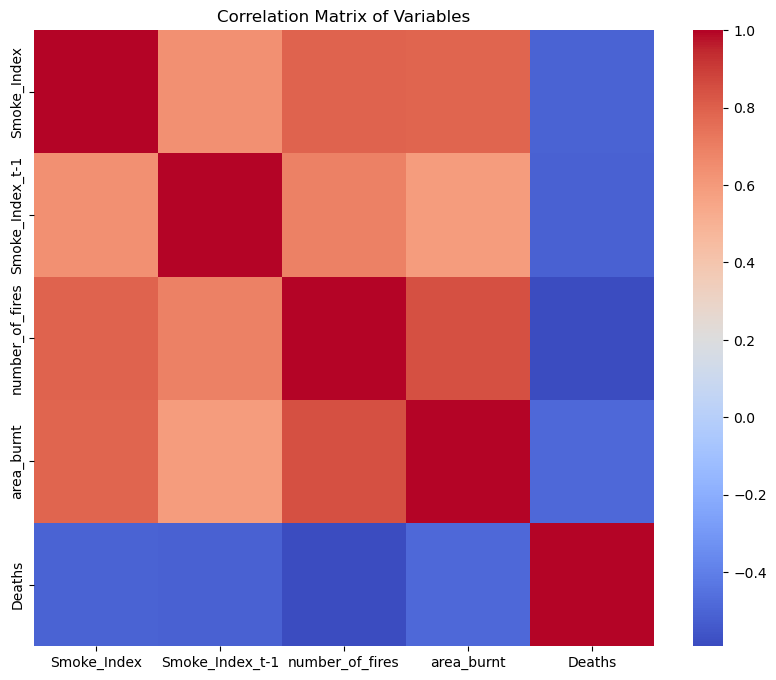

In [ ]:
# Select variables for correlation analysis
correlation_data = combined_data[['Smoke_Index', 'Smoke_Index_t-1', 'number_of_fires', 'area_burnt', 'Deaths']]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Variables")
plt.show()

The above correlation matrix shoes negative correlation of Deaths with every smoke and fire related variable (blue boxes). This could again be because of the overwhelming downward trend in Deaths. So to account for it, we first detrend our variables by subtracting a linear approximation of their time trend from the variable. Then we calculate correlation on these detrended variables.

In [40]:
# De-trend deaths
years = combined_data['Year']
slope, intercept, _, _, _ = linregress(years, combined_data['Deaths'])
combined_data['Deaths_detrended'] = combined_data['Deaths'] - (slope * years + intercept)

# De-trend smoke index
slope, intercept, _, _, _ = linregress(years, combined_data['Smoke_Index'])
combined_data['Smoke_Index_detrended'] = combined_data['Smoke_Index'] - (slope * years + intercept)

# De-trend smoke index
slope, intercept, _, _, _ = linregress(years, combined_data['number_of_fires'])
combined_data['number_of_fires_detrended'] = combined_data['number_of_fires'] - (slope * years + intercept)

# De-trend smoke index
slope, intercept, _, _, _ = linregress(years, combined_data['area_burnt'])
combined_data['area_burnt_detrended'] = combined_data['area_burnt'] - (slope * years + intercept)

# Recompute correlation matrix
correlation_matrix_detrended = combined_data[['Smoke_Index_detrended', 'number_of_fires_detrended', 'area_burnt_detrended', 'Deaths_detrended']].corr()
print(correlation_matrix_detrended)



                           Smoke_Index_detrended  number_of_fires_detrended  \
Smoke_Index_detrended                   1.000000                   0.513428   
number_of_fires_detrended               0.513428                   1.000000   
area_burnt_detrended                    0.562487                   0.680313   
Deaths_detrended                        0.058282                  -0.061204   

                           area_burnt_detrended  Deaths_detrended  
Smoke_Index_detrended                  0.562487          0.058282  
number_of_fires_detrended              0.680313         -0.061204  
area_burnt_detrended                   1.000000          0.036750  
Deaths_detrended                       0.036750          1.000000  


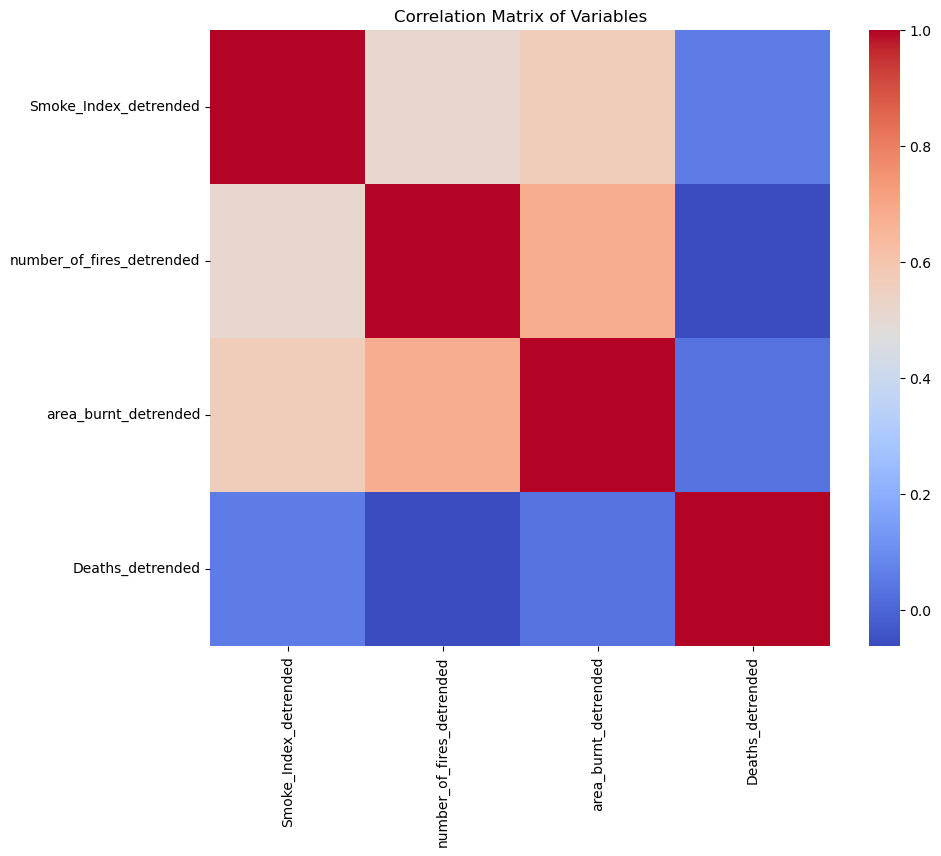

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_detrended, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Variables")
plt.show()

We find that detrending variables has allowed us to uncover a small positive correlation between Deaths and smoke variables. We build on this by trying to fit a linear model that predicts Deaths with time as a regressor.

In [ ]:
# Add time variable to capture trends
combined_data['time'] = combined_data['Year'] - combined_data['Year'].min()

# Prepare features and target
X = combined_data[['Smoke_Index', 'Smoke_Index_t-1', 'number_of_fires', 'area_burnt', 'time']]
y = combined_data['Deaths']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


Mean Absolute Error: 58.14
R² Score: 0.55


In [ ]:
# Print coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

This linear model explains 55% of variance in Deaths (as evidenced by the R square metric). The coefficients also show a positive contribution of Smoke index to Deaths and a negative contribution of time to Deaths. The other variables have very low coefficients and we will ignore them for future modelling.

## Modelling Respiratory Deaths 

Now we try to fit a time series model for our analysis. We use Meta's Prophet model because it is robust to missing data and shifts in the trend, and typically handles outliers well. We first use the model to forecast Deaths to 2050 using the last known values of the smoke index.

/Users/apoorvasheera/anaconda3/envs/MLTutorial/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:18 - cmdstanpy - INFO - Chain [1] done processing


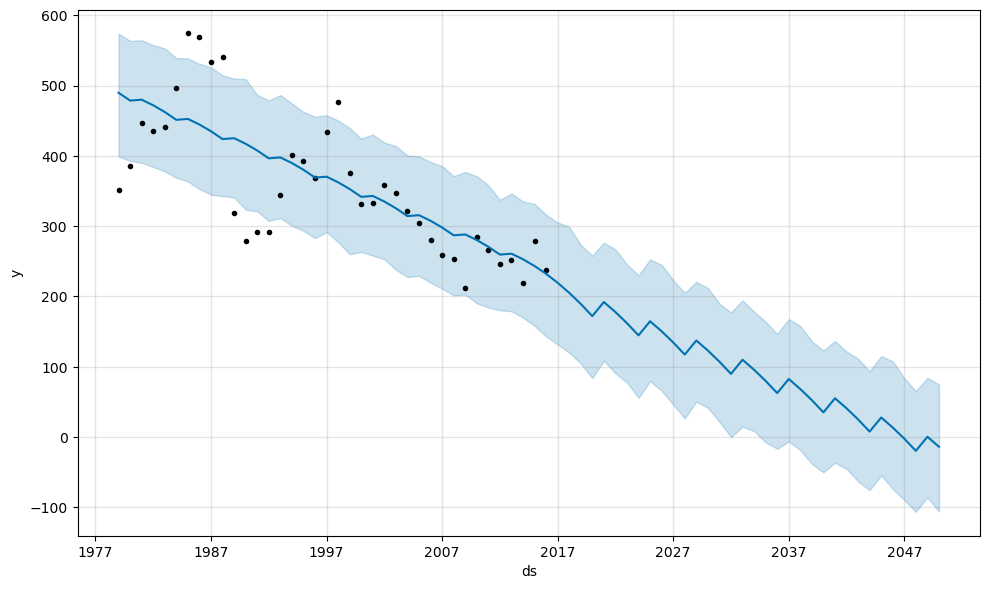

In [ ]:
# Prepare data for Prophet
prophet_data = combined_data[['Year', 'Deaths', 'Smoke_Index']].rename(
    columns={'Year': 'ds', 'Deaths': 'y', 'Smoke_Index': 'smoke'}
)
# Ensure 'ds' column is in datetime format
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'], format='%Y')

# Initialize Prophet model
model = Prophet()
model.add_regressor('smoke')

# Fit the model
model.fit(prophet_data)

# Forecast future deaths
future = model.make_future_dataframe(periods=2050 - prophet_data['ds'].dt.year.max(), freq='Y')  # Extend to 2050
future['smoke'] = combined_data['Smoke_Index'].iloc[-1]  # Use the last available smoke index

# Predict
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()


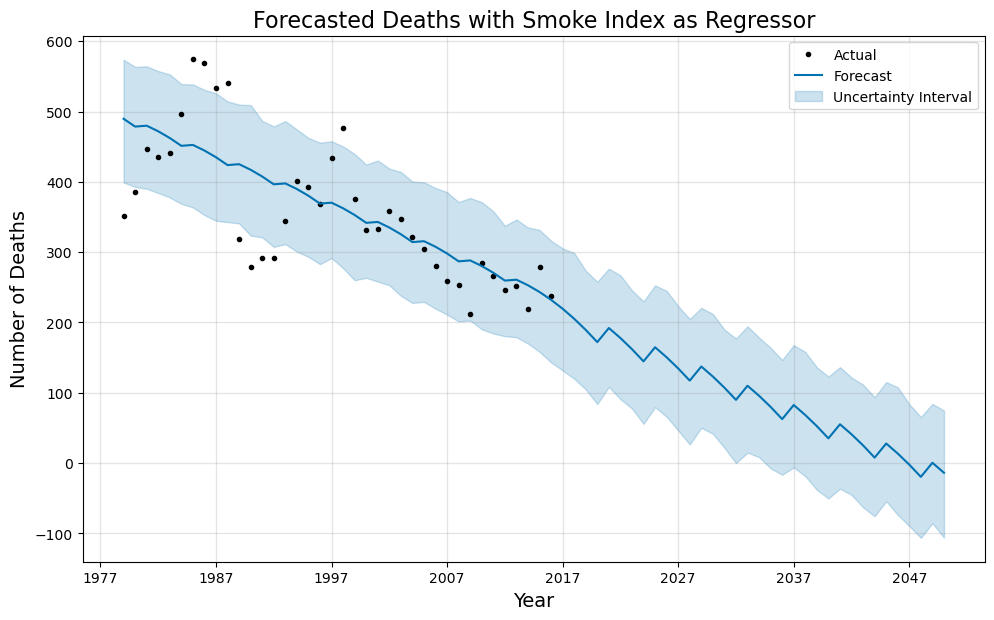

In [45]:
# Plot the forecast
fig = model.plot(forecast)

# Customize the plot
ax = fig.gca()  # Get the current axes

# Add title and labels
ax.set_title('Forecasted Deaths with Smoke Index as Regressor', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Number of Deaths', fontsize=14)

# Add a legend
ax.legend(['Actual', 'Forecast', 'Uncertainty Interval'], loc='upper right')

# Show the plot
plt.show()

Now we would like to use our forcasted smoke index to improve our predictions of Deaths. So we prepare our smoke index forecast and feed it to our Prophet model

In [47]:
# Read forecasted smoke data
yearly_smoke_forecast = pd.read_csv('../common-analysis/final-data/year_smoke_index_forecast.csv')

# Rename columns
forecasted_smoke = yearly_smoke_forecast.rename(columns={'yhat': 'smoke'})

# Convert 'ds' to datetime format
forecasted_smoke['ds'] = pd.to_datetime(forecasted_smoke['ds'], format='%Y-%m-%d')

# Filter rows between 2021 and 2049
forecasted_smoke = forecasted_smoke[
    (forecasted_smoke['ds'].dt.year >= 2021) & (forecasted_smoke['ds'].dt.year <= 2049)
]


In [48]:
# Add real smoke estimates for 2017–2020 from yearly_smoke_index
real_smoke = yearly_smoke_index[
    yearly_smoke_index['Year'].between(2017, 2020)
].rename(columns={'Year': 'ds', 'yearly_smoke_index': 'smoke'})

# Convert 'ds' to datetime format
real_smoke['ds'] = pd.to_datetime(real_smoke['ds'], format='%Y')

# Normalize dates to the end of each year (YYYY-12-31) while keeping datetime format
real_smoke['ds'] = real_smoke['ds'] + pd.offsets.YearEnd(0)

# Add a placeholder for death values (if needed)
real_smoke['y'] = None  # Death values are unknown for 2017–2020

In [49]:
real_smoke

,ds,smoke,y
92,2017-12-31,0.978377,None
93,2018-12-31,0.984609,None
94,2019-12-31,1.980190,None
95,2020-12-31,0.923078,None


18:45:48 - cmdstanpy - INFO - Chain [1] start processing
18:45:48 - cmdstanpy - INFO - Chain [1] done processing


Empty DataFrame
Columns: [ds, smoke]
Index: []


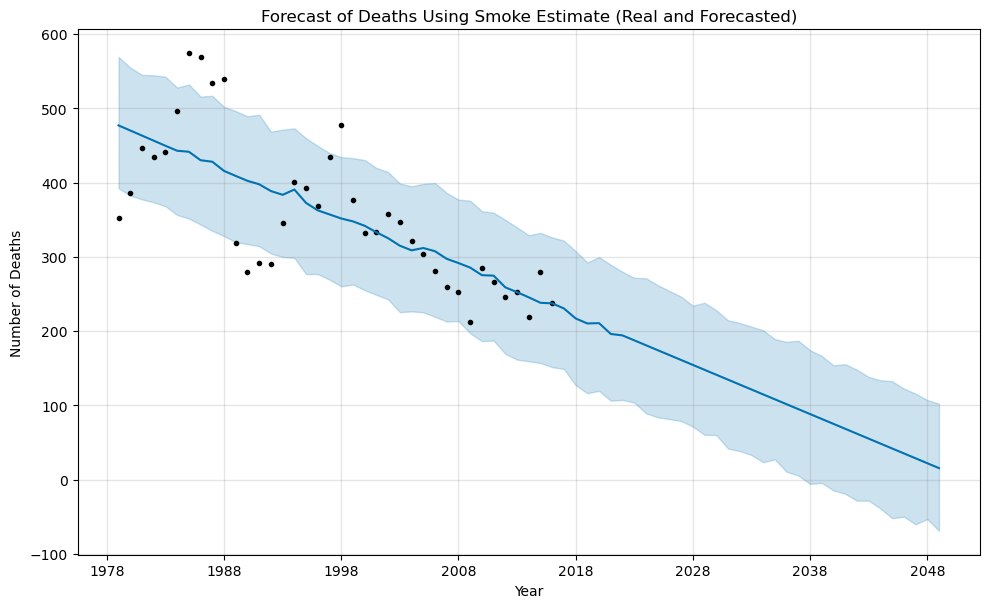

In [ ]:
# Prepare data for Prophet
prophet_data = combined_data[['Year', 'Deaths', 'Smoke_Index']].rename(
    columns={'Year': 'ds', 'Deaths': 'y', 'Smoke_Index': 'smoke'}
)

# Ensure 'ds' column is in datetime format
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'], format='%Y')

# Combine Prophet data with real smoke estimates (2017–2020) and forecasted smoke estimates (2021–2050)
combined_smoke = pd.concat([prophet_data, real_smoke, forecasted_smoke], ignore_index=True)

# Initialize Prophet model
model = Prophet(yearly_seasonality=False)
model.add_regressor('smoke')

# Fit the model
model.fit(combined_smoke)

# Create a future DataFrame for predictions
future = model.make_future_dataframe(periods=2049 - prophet_data['ds'].dt.year.max(), freq='Y')

# Merge smoke values into the future DataFrame

future = future.merge(pd.concat([prophet_data,real_smoke, forecasted_smoke])[['ds', 'smoke']], on='ds', how='left')
future['smoke'] = future['smoke'].ffill()

# Print rows for which future dataframe has NaN values
print(future[future.isna().any(axis=1)])

# Predict future deaths
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Forecast of Deaths Using Smoke Estimate (Real and Forecasted)")
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.show()


Making a labelled plot

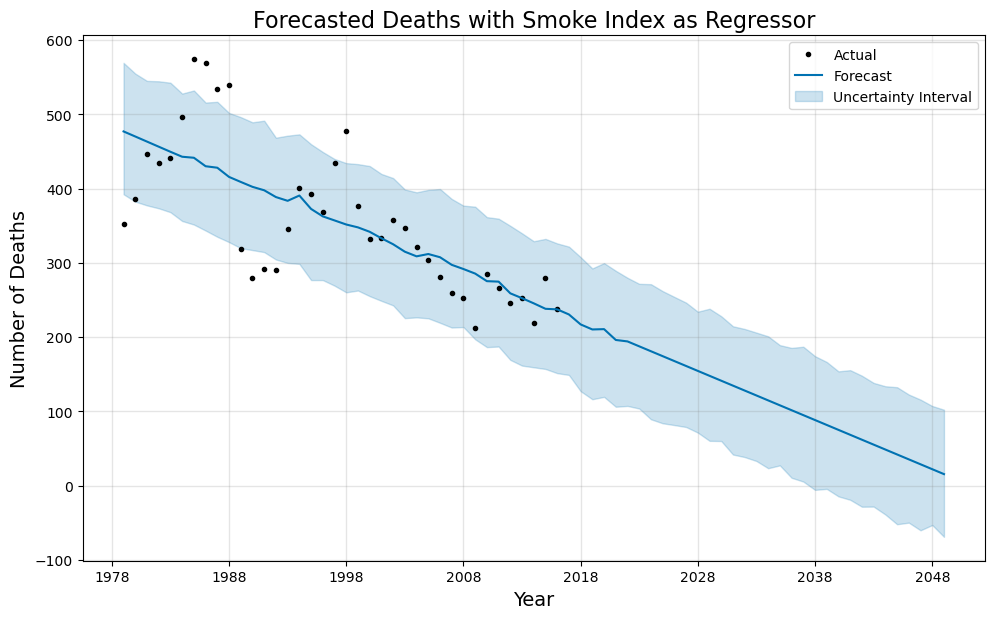

In [51]:
# Plot the forecast
fig = model.plot(forecast)

# Customize the plot
ax = fig.gca()  # Get the current axes

# Add title and labels
ax.set_title('Forecasted Deaths with Smoke Index as Regressor', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Number of Deaths', fontsize=14)

# Add a legend
ax.legend(['Actual', 'Forecast', 'Uncertainty Interval'], loc='upper right')

# Show the plot
plt.show()

We evaluate the fit of our model by calculating MAE nad RMSE, we find that this model does better than the Linear regression we fitted earlier.

In [52]:
# Make in-sample predictions
forecast_in_sample = model.predict(prophet_data)

# Calculate residuals
prophet_data['yhat'] = forecast_in_sample['yhat']
prophet_data['residual'] = prophet_data['y'] - prophet_data['yhat']

# Calculate common fit statistics
mae = prophet_data['residual'].abs().mean()  # Mean Absolute Error
mse = (prophet_data['residual'] ** 2).mean()  # Mean Squared Error
rmse = mse ** 0.5  # Root Mean Squared Error

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 50.20
Root Mean Squared Error (RMSE): 67.44


To isolate the impact of smoke index on the number of predicted Deaths, we can plot components of our forcast. We can see that extra_regressor_additive which indicates the effect of our smoke index is positive and increasing over the years.

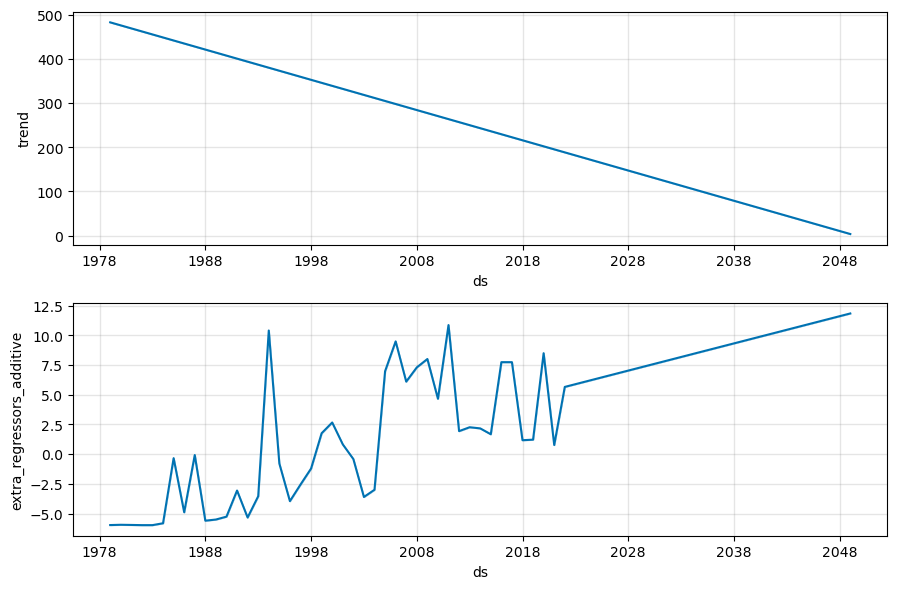

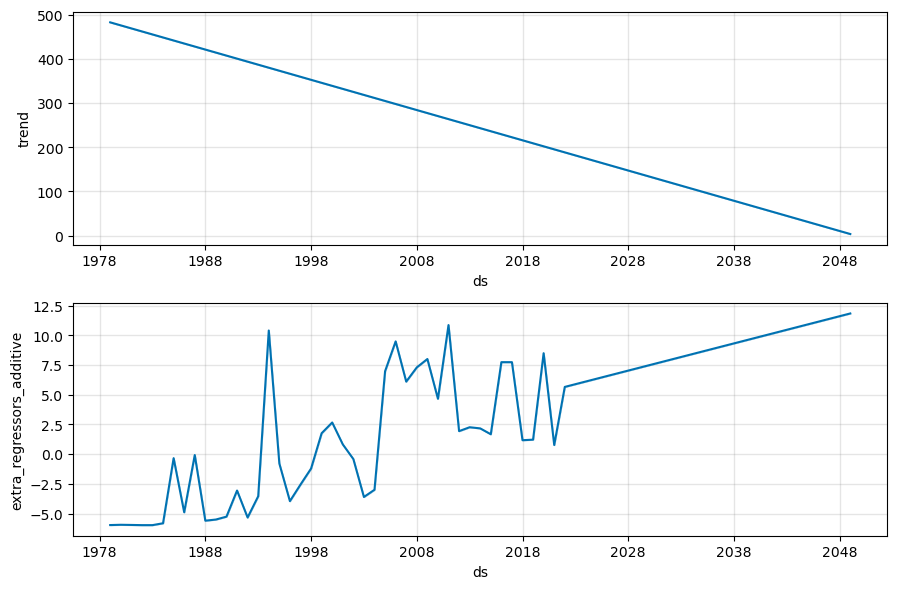

In [189]:
model.plot_components(forecast)

## Demographic Analysis

To further evaluate the impact of smoke on respiratory deaths, we would also like to see how it impacts different genders and if there are a particular gender is disproportionatly impacted.

In [61]:
mortality.head(5)

,Notes,Age Group,Age Group Code,Race,Race Code,Gender,Gender Code,Cause of death,Cause of death Code,Year,Year Code,Deaths,Population,Crude Rate,% of Total Deaths
0,NaN,< 1 year,1,Black or African American,2054-5,Female,F,"Other diseases of larynx, not elsewhere classi...",478.7,1986.0,1986.0,1.0,2189.0,45.7 (Unreliable),0.0%
1,NaN,< 1 year,1,Black or African American,2054-5,Female,F,"Pneumonia, organism unspecified",486.0,1983.0,1983.0,1.0,2075.0,48.2 (Unreliable),0.0%
2,NaN,< 1 year,1,Black or African American,2054-5,Female,F,"Pneumonia, organism unspecified",486.0,1987.0,1987.0,1.0,2142.0,46.7 (Unreliable),0.0%
3,NaN,< 1 year,1,Black or African American,2054-5,Female,F,Pulmonary collapse,518.0,1979.0,1979.0,1.0,2274.0,44.0 (Unreliable),0.0%
4,NaN,< 1 year,1,Black or African American,2054-5,Female,F,Other diseases of lung,518.8,1980.0,1980.0,1.0,2318.0,43.1 (Unreliable),0.0%


In [60]:
mortality_gender = mortality.groupby(['Year', 'Gender']).agg({'Deaths': 'sum'}).reset_index()
mortality_gender_pivot = mortality_gender.pivot(index='Year', columns='Gender', values='Deaths').reset_index()
mortality_gender_pivot.columns.name = None  # Remove the pivot table's column name
mortality_gender_pivot.head(5)

,Year,Female,Male
0,1979.0,121.0,231.0
1,1980.0,131.0,255.0
2,1981.0,165.0,282.0
3,1982.0,163.0,272.0
4,1983.0,187.0,254.0


In [62]:
# Merge the datasets on the year
combined_data_gender = pd.merge(yearly_smoke_index, mortality_gender_pivot, on='Year', how='inner')
combined_data_gender.rename(columns={"yearly_smoke_index":"Smoke_Index"}, inplace=True)
combined_data_gender.head(5)

,Year,Smoke_Index,Female,Male
0,1979,0.001309,121.0,231.0
1,1980,0.004536,131.0,255.0
2,1981,0.002687,165.0,282.0
3,1982,0.000443,163.0,272.0
4,1983,0.000416,187.0,254.0


In [64]:
combined_data_gender.columns

Index(['Year', 'Smoke_Index', 'Female', 'Male'], dtype='object')

             Smoke_Index    Female      Male
Smoke_Index     1.000000 -0.189304 -0.612699
Female         -0.189304  1.000000  0.534308
Male           -0.612699  0.534308  1.000000


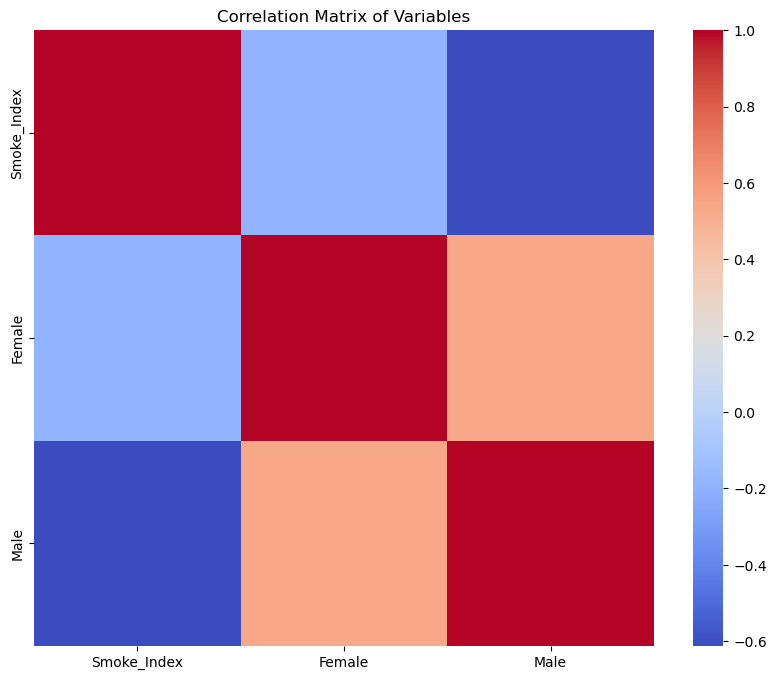

In [67]:
# Select variables for correlation analysis
correlation_data = combined_data_gender[['Smoke_Index', 'Female', 'Male']]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Variables")
plt.show()

In [68]:
# De-trend Male
years = combined_data_gender['Year']
slope, intercept, _, _, _ = linregress(years, combined_data_gender['Male'])
combined_data_gender['Male_detrended'] = combined_data_gender['Male'] - (slope * years + intercept)

# De-trend Male
years = combined_data_gender['Year']
slope, intercept, _, _, _ = linregress(years, combined_data_gender['Female'])
combined_data_gender['Female_detrended'] = combined_data_gender['Female'] - (slope * years + intercept)

# De-trend smoke index
slope, intercept, _, _, _ = linregress(years, combined_data_gender['Smoke_Index'])
combined_data_gender['Smoke_Index_detrended'] = combined_data_gender['Smoke_Index'] - (slope * years + intercept)

# Recompute correlation matrix
correlation_matrix_detrended = combined_data_gender[['Smoke_Index_detrended','Male_detrended','Female_detrended']].corr()
print(correlation_matrix_detrended)



                       Smoke_Index_detrended  Male_detrended  Female_detrended
Smoke_Index_detrended               1.000000        0.041316          0.059935
Male_detrended                      0.041316        1.000000          0.543147
Female_detrended                    0.059935        0.543147          1.000000


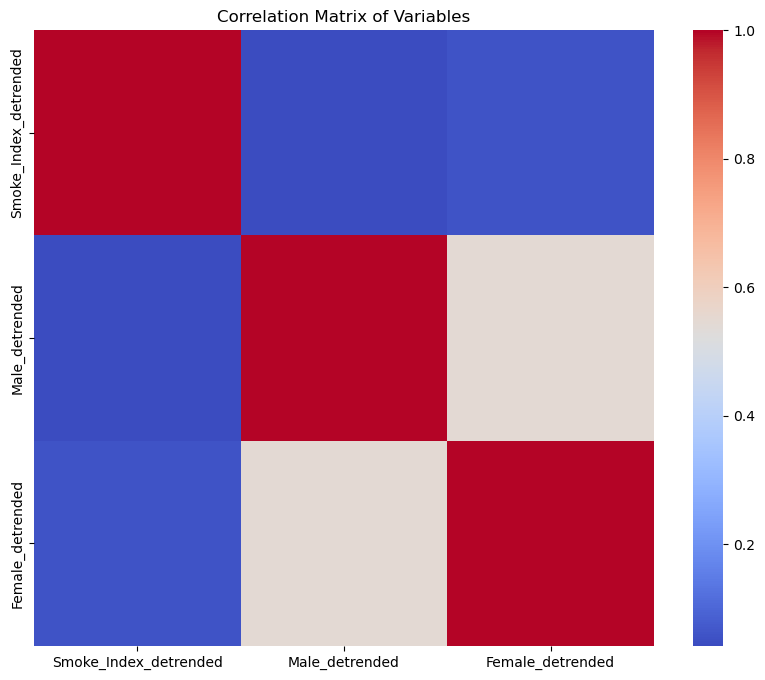

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_detrended, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Variables")
plt.show()

We see a higher correlation of Female Deaths to Smoke Index than of Male deaths to Smoke Index when we detrend our variables

Now we fit two prophet models to our data

19:45:07 - cmdstanpy - INFO - Chain [1] start processing
19:45:07 - cmdstanpy - INFO - Chain [1] done processing


Empty DataFrame
Columns: [ds, smoke]
Index: []


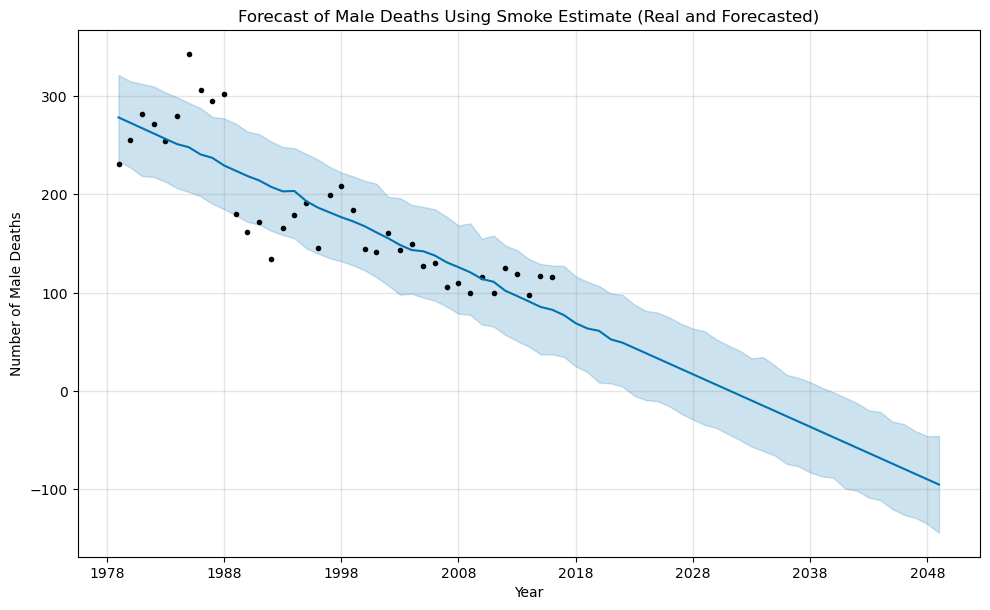

In [72]:
# Modelling Male deaths with smoke index

# Prepare data for Prophet
prophet_data = combined_data_gender[['Year', 'Male', 'Smoke_Index']].rename(
    columns={'Year': 'ds', 'Male': 'y', 'Smoke_Index': 'smoke'}
)

# Ensure 'ds' column is in datetime format
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'], format='%Y')

# Combine Prophet data with real smoke estimates (2017–2020) and forecasted smoke estimates (2021–2050)
combined_smoke = pd.concat([prophet_data, real_smoke, forecasted_smoke], ignore_index=True)

# Initialize Prophet model
model = Prophet(yearly_seasonality=False)
model.add_regressor('smoke')

# Fit the model
model.fit(combined_smoke)

# Create a future DataFrame for predictions
future = model.make_future_dataframe(periods=2049 - prophet_data['ds'].dt.year.max(), freq='Y')

# Merge smoke values into the future DataFrame

future = future.merge(pd.concat([prophet_data,real_smoke, forecasted_smoke])[['ds', 'smoke']], on='ds', how='left')
future['smoke'] = future['smoke'].ffill()

# Print rows for which future dataframe has NaN values
print(future[future.isna().any(axis=1)])

# Predict future deaths
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Forecast of Male Deaths Using Smoke Estimate (Real and Forecasted)")
plt.xlabel("Year")
plt.ylabel("Number of Male Deaths")
plt.show()


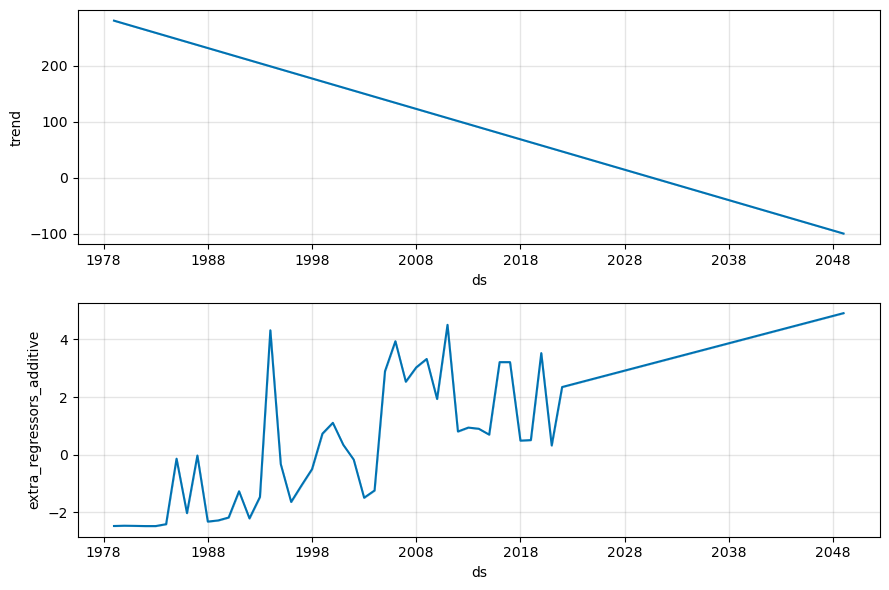

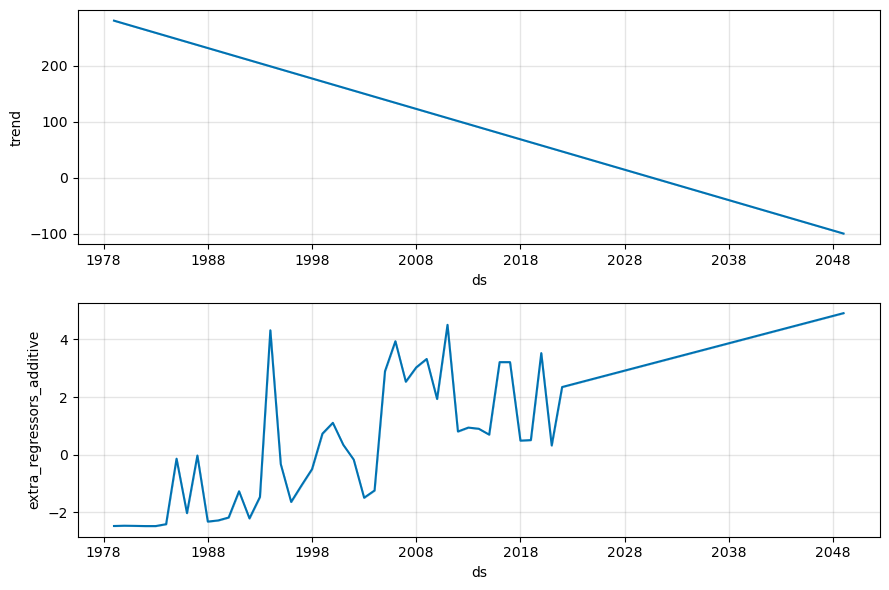

In [73]:
model.plot_components(forecast)

19:45:38 - cmdstanpy - INFO - Chain [1] start processing
19:45:39 - cmdstanpy - INFO - Chain [1] done processing


Empty DataFrame
Columns: [ds, smoke]
Index: []


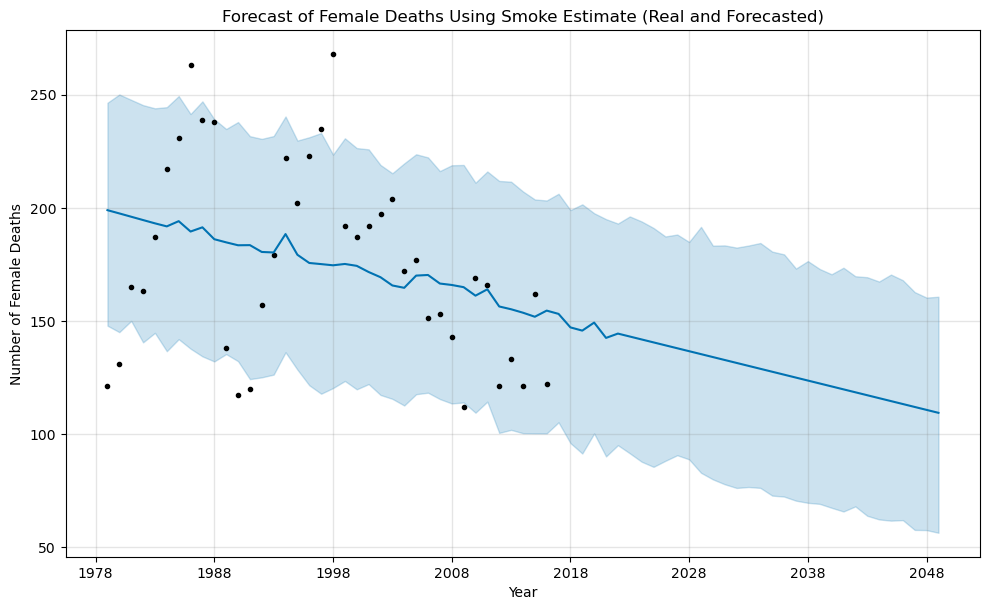

In [74]:
# Modelling Female deaths with smoke index

# Prepare data for Prophet
prophet_data = combined_data_gender[['Year', 'Female', 'Smoke_Index']].rename(
    columns={'Year': 'ds', 'Female': 'y', 'Smoke_Index': 'smoke'}
)

# Ensure 'ds' column is in datetime format
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'], format='%Y')

# Combine Prophet data with real smoke estimates (2017–2020) and forecasted smoke estimates (2021–2050)
combined_smoke = pd.concat([prophet_data, real_smoke, forecasted_smoke], ignore_index=True)

# Initialize Prophet model
model = Prophet(yearly_seasonality=False)
model.add_regressor('smoke')

# Fit the model
model.fit(combined_smoke)

# Create a future DataFrame for predictions
future = model.make_future_dataframe(periods=2049 - prophet_data['ds'].dt.year.max(), freq='Y')

# Merge smoke values into the future DataFrame

future = future.merge(pd.concat([prophet_data,real_smoke, forecasted_smoke])[['ds', 'smoke']], on='ds', how='left')
future['smoke'] = future['smoke'].ffill()

# Print rows for which future dataframe has NaN values
print(future[future.isna().any(axis=1)])

# Predict future deaths
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Forecast of Female Deaths Using Smoke Estimate (Real and Forecasted)")
plt.xlabel("Year")
plt.ylabel("Number of Female Deaths")
plt.show()


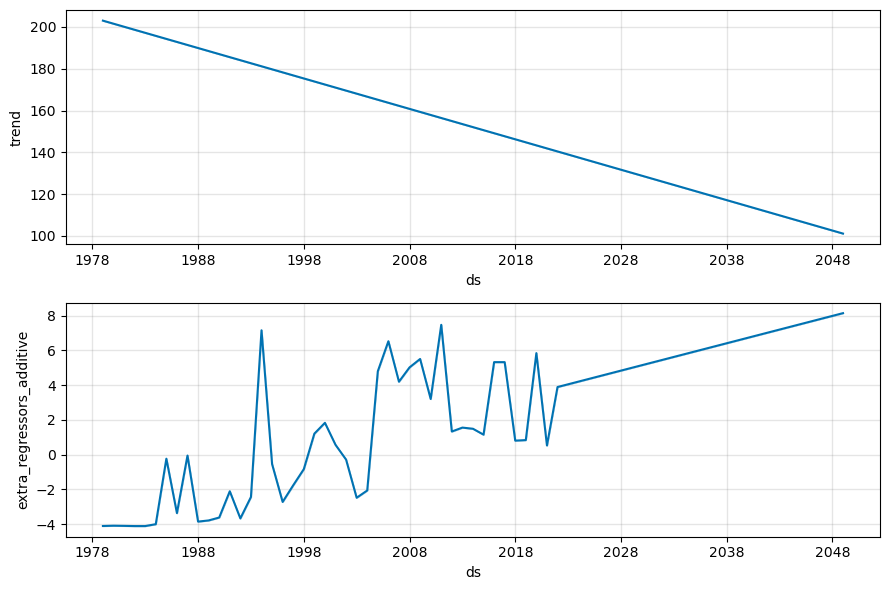

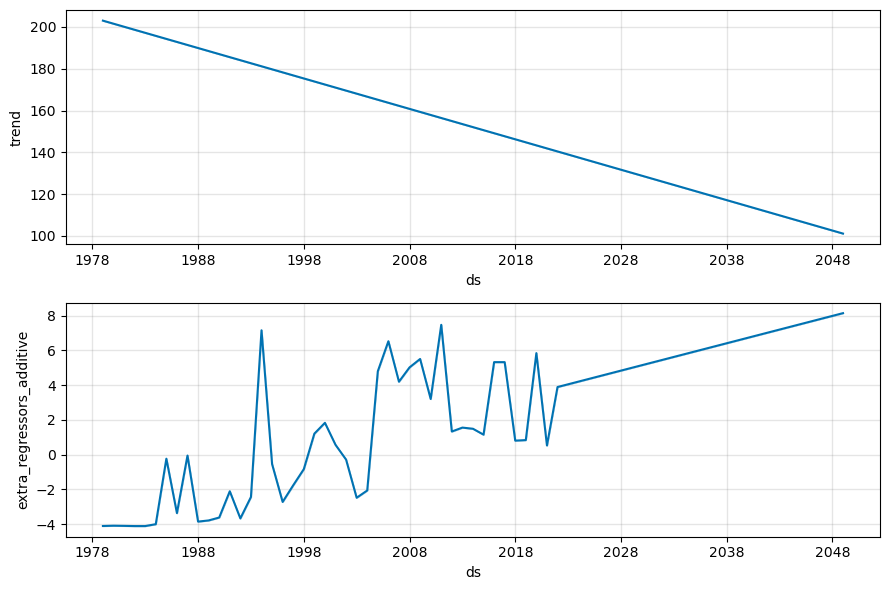

In [75]:
model.plot_components(forecast)

These models reveal some very interesting patterns:
1. Male Mortality from Respiratory diseases has declined and will continue to decline much steeper that Female Mortality
2. The impact of high smoke on Female mortality in the upcoming years is projected to be add almost double the number of deaths compared to the impact of smoke on Male mortality 